# Debate Decoder: Unveiling Key Parliamentary Themes

## Introduction

The Canadian House of Commons debates vital issues like housing, Indigenous rights, and military justice, but the volume of discussions makes analysis challenging. This project uses **Latent Dirichlet Allocation (LDA)** to extract and visualize key topics, promoting transparency, informed decision-making, and advocacy.

### Objectives:
- Identify key themes in parliamentary debates.
- Provide actionable insights for policymakers and advocacy groups.
- Enhance understanding through interactive visualizations.

This project simplifies complex discussions into clear, actionable insights for stakeholders.


## Imports
- **pandas**: For data manipulation and cleaning.
- **gensim**: For topic modeling and LDA implementation.
- **nltk**: For text preprocessing, such as tokenization and stop word removal.
- **pyLDAvis**: For interactive visualization of LDA topics.

In [1]:
import pandas as pd
import gensim
import nltk
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel, Phrases
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import re

In [2]:
# Load the dataset containing parliamentary debates
data = pd.read_csv('Hansard1.csv', encoding='ISO-8859-1')

## Data Preview
Displaying the first few rows of the dataset to understand its structure and identify columns for cleaning.

In [3]:
# Display the first few rows of the dataset
data.head()

,Publication,First Name,Last Name,Constituency,Caucus,Province,Date,Time,Page,Text,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,Hansard - 340,Carol,Hughes,Algoma-Manitoulin-Kapuskasing,NDP,ON,2024-09-20,10:03:57,25647.0,The Assistant Deputy Speaker (Mrs. Carol Hughe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hansard - 340,Philip,Lawrence,Northumberland-Peterborough South,CPC,ON,2024-09-20,10:03:58,25647.0,Mr. Philip Lawrence (Northumberland-Peterborou...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hansard - 340,Elizabeth,May,Saanich-Gulf Islands,GP,BC,2024-09-20,10:23:38,25649.0,"Ms. Elizabeth May (Saanich-Gulf Islands, GP)(1...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hansard - 340,Richard,Cannings,South Okanagan-West Kootenay,NDP,BC,2024-09-20,10:23:38,25649.0,Mr. Richard Cannings (South Okanagan-West Koot...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hansard - 340,Philip,Lawrence,Northumberland-Peterborough South,CPC,ON,2024-09-20,10:23:38,25649.0,Mr. Philip Lawrence (Northumberland-Peterborou...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Drop unnecessary columns such as 'Publication', 'Page', and unnamed columns

columns_to_drop = ['Publication', 'Page'] + [col for col in data.columns if 'Unnamed' in col]
data = data.drop(columns=columns_to_drop)

# Display the cleaned data to verify column removal
data.head()

,First Name,Last Name,Constituency,Caucus,Province,Date,Time,Text
0,Carol,Hughes,Algoma-Manitoulin-Kapuskasing,NDP,ON,2024-09-20,10:03:57,The Assistant Deputy Speaker (Mrs. Carol Hughe...
1,Philip,Lawrence,Northumberland-Peterborough South,CPC,ON,2024-09-20,10:03:58,Mr. Philip Lawrence (Northumberland-Peterborou...
2,Elizabeth,May,Saanich-Gulf Islands,GP,BC,2024-09-20,10:23:38,"Ms. Elizabeth May (Saanich-Gulf Islands, GP)(1..."
3,Richard,Cannings,South Okanagan-West Kootenay,NDP,BC,2024-09-20,10:23:38,Mr. Richard Cannings (South Okanagan-West Koot...
4,Philip,Lawrence,Northumberland-Peterborough South,CPC,ON,2024-09-20,10:23:38,Mr. Philip Lawrence (Northumberland-Peterborou...


In [5]:
# Replaced missing values in the 'Text' column with empty strings to avoid errors during text processing

data['Text'] = data['Text'].fillna('')

## Text Preprocessing
The text data undergoes several preprocessing steps to prepare it for topic modeling:
- **Tokenization**: Splitting text into individual words.
- **Stop Word Removal**: Eliminating common words that do not contribute to meaning (e.g., "the", "and").
- **Lemmatization**: Converting words to their base form for consistency.

In [6]:
# Initialize stopwords and lemmatizer
stop_words = stopwords.words('english')

# Add custom stopwords
additional_stopwords = [
    'government', 'speaker', 'minister', 'member', 'mr', 'hon', 'house', 'bill',
    'committee', 'would', 'also', 'one', 'like', 'get', 'know', 'want', 'canadians', 
    'people', 'canada', 'years', 'work', 'english', 'canadian', 'madam', 'mr', 'leader', 
    'country', 'liberal', 'ndp', 'party', 'federal', 'think', 'said', 'thank', 'going', 'u',
    'today', 'say', 'many', 'member', 'conservative', 'need','ask'
]
stop_words.extend(additional_stopwords)

lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess(text):
    if not isinstance(text, str):
        return []
    
    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    # Convert to lowercase and tokenize the text data into individual words
    tokens = simple_preprocess(text.lower(), deacc=True)

    # Lemmatize and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens


In [7]:
# Apply preprocessing
data['processed_Text'] = data['Text'].apply(preprocess)

# Create bigrams model after tokenizing
bigram_model = Phrases(data['processed_Text'], min_count=5, threshold=100)
bigram_phraser = bigram_model[data['processed_Text']]

# Update the 'processed_Text' column with bigrams
# Corrected: Apply the bigram model correctly
data['processed_Text'] = [bigram_model[text] for text in data['processed_Text']]

In [8]:
# Create Dictionary and Corpus
dictionary = corpora.Dictionary(data['processed_Text'])
# Filter out extremes
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in data['processed_Text']]

## LDA Model Training
Latent Dirichlet Allocation (LDA) is used to extract topics from the text. Key parameters:
- **num_topics**: The number of topics to extract.
- **passes**: The number of passes through the dataset for training.
- **alpha, eta**: Hyperparameters controlling topic distribution.

In [9]:
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=7, 
                     random_state=100,
                     update_every=1,
                     chunksize=4000,
                     passes=10,
                     alpha='auto',
                     eta='auto',
                     per_word_topics=True)

C:\Users\Agban\anaconda3\Lib\site-packages\gensim\models\ldamodel.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [10]:
for i in range(7):
    print(f'Topic {i+1}:')
    print([term for term, _ in lda_model.show_topic(i, topn=25)])
    print('\n')

Topic 1:
['citizenship', 'child', 'legislation', 'right', 'time', 'u', 'citizen', 'support', 'act', 'conservative', 'family', 'issue', 'member', 'important', 'amendment', 'court', 'lost', 'take', 'section', 'parent', 'law', 'individual', 'way', 'call', 'force']


Topic 2:
['community', 'lib', 'support', 'conservative', 'way', 'chuck', 'time', 'indigenous', 'colleague', 'friend', 'thing', 'place', 'service', 'u', 'across', 'back', 'continue', 'always', 'important', 'day', 'served', 'go', 'family', 'public', 'see']


Topic 3:
['housing', 'home', 'time', 'carbon_tax', 'liberal', 'food', 'prime', 'cost', 'tax', 'community', 'cpc', 'conservative', 'nine', 'year', 'affordable', 'million', 'build', 'number', 'billion', 'policy', 'city', 'price', 'new', 'election', 'built']


Topic 4:
['quebec', 'translation', 'bloc_quebecois', 'quebeckers', 'lib', 'senior', 'support', 'colleague', 'program', 'riding', 'money', 'bloc', 'liberal', 'port', 'prime', 'u', 'city', 'community', 'plan', 'help', 'otta

## Visualization
The pyLDAvis plot provides an interactive way to explore topics:
- Circles represent topics, with their size indicating prevalence.
- Terms most relevant to each topic are displayed on the right.

In [11]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Display the pyLDAvis visualization
pyLDAvis.display(vis)

In [12]:
from gensim.models import CoherenceModel

# Assuming `lda_model` is your trained LDA model, `corpus` is your bag-of-words, and `texts` is the tokenized text

coherence_model_lda = CoherenceModel(model=lda_model, texts=data['processed_Text'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()

print(f'Coherence Score: {coherence_score}')



Coherence Score: 0.4902596002861642


In [13]:
# Get the topic distribution for each document
topic_distributions = []
for bow in corpus:
    topic_distribution = lda_model.get_document_topics(bow, minimum_probability=0)
    topic_distributions.append([weight for _, weight in topic_distribution])

# Create a DataFrame
topic_df = pd.DataFrame(topic_distributions, columns=[f'Topic_{i+1}' for i in range(lda_model.num_topics)])

# Add the processed text to the DataFrame
topic_df.insert(0, 'Processed_Text', data['processed_Text'])

# Add a "Dominant_Topic" column with the name of the topic with the highest weight
topic_df['Dominant_Topic'] = topic_df.iloc[:, 1:].idxmax(axis=1)

topic_df.head(10)

,Processed_Text,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Dominant_Topic
0,"[assistant_deputy, mr_carol, hughes, motion, a...",0.072435,0.005210,0.006222,0.005700,0.900523,0.005223,0.004686,Topic_5
1,"[philip_lawrence, northumberland_peterborough,...",0.012028,0.012321,0.471126,0.013508,0.467575,0.012362,0.011080,Topic_3
2,"[m_elizabeth, may_saanich, gulf_island, gp, se...",0.004102,0.004201,0.005011,0.004592,0.974103,0.004211,0.003779,Topic_5
3,"[richard_cannings, south_okanagan, west_kooten...",0.002956,0.003028,0.003612,0.003310,0.981335,0.003035,0.002723,Topic_5
4,"[philip_lawrence, northumberland_peterborough,...",0.015546,0.015923,0.489656,0.017410,0.431183,0.015961,0.014320,Topic_3
5,"[philip_lawrence, northumberland_peterborough,...",0.113641,0.000265,0.638899,0.115757,0.130935,0.000265,0.000238,Topic_3
6,"[chandra, arya, nepean, lib, listened, colleag...",0.002005,0.002054,0.002454,0.523832,0.465747,0.002059,0.001847,Topic_4
7,"[philip_lawrence, reason, behind, productivity...",0.006697,0.006860,0.956826,0.007502,0.009070,0.006876,0.006168,Topic_3
8,"[m_christine, normandin_saint, jean_bq, transl...",0.005089,0.005211,0.006220,0.459420,0.006880,0.512493,0.004686,Topic_6
9,"[philip_lawrence, course, conservative, contin...",0.089330,0.003638,0.891325,0.003979,0.004810,0.003647,0.003272,Topic_3


In [14]:
topic_df['Dominant_Topic'].value_counts()

Dominant_Topic
Topic_5    4709
Topic_3     270
Topic_4     168
Topic_1      96
Topic_6      88
Topic_2      87
Topic_7      36
Name: count, dtype: int64

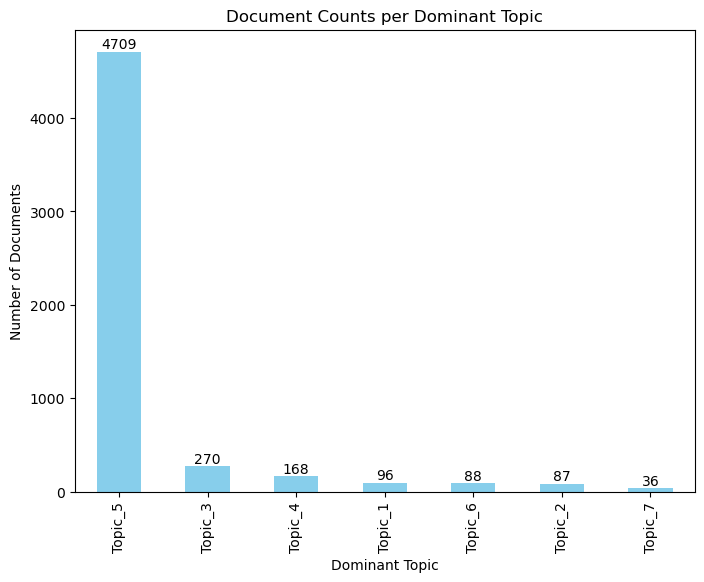

In [15]:
import matplotlib.pyplot as plt

# Assuming topic_df['Dominant_Topic'] contains the dominant topic for each document
# Count the occurrences of each topic
topic_counts = topic_df['Dominant_Topic'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = topic_counts.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Document Counts per Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Documents')

# Add counts on top of each bar
for i, count in enumerate(topic_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

# Show the plot
plt.show()


### Quantitative Findings

- The model successfully identified distinct topics, achieving a **coherence score of 0.49**, indicating that the topics are interpretable and meaningful.
- **Topic 5** emerged as the most discussed topic, suggesting that a significant portion of parliamentary debates focused on **procedural matters, housing policy, and related governmental issues**.


In [16]:
topic_counts_matrix = topic_df['Dominant_Topic'].value_counts().reset_index()
topic_counts_matrix.columns = ['Dominant_Topic', 'Document_Counts']

# Display the matrix-like table
print(topic_counts_matrix)

  Dominant_Topic  Document_Counts
0        Topic_5             4709
1        Topic_3              270
2        Topic_4              168
3        Topic_1               96
4        Topic_6               88
5        Topic_2               87
6        Topic_7               36


### Example of Topic 3: Housing and Economic Policy

Below is an example of the raw text classified under **Topic 3**, which focuses on debates about housing and economic policy:

In [17]:
first_text = data['Text'].iloc[7]
first_text

"Mr. Philip Lawrence: (1030)[English]Madam Speaker, one of the reasons behind Canada's productivity is that Canada has been among the worst when it comes to developed countries' attracting capital.We absolutely need capital, but the only way we are going to get more capital and increase productivity is to have a carbon tax election."

## Results

The topic modeling analysis identified the following key themes and their most relevant terms from the parliamentary debates:

### Topic 1: Citizenship and Legal Rights
- **Key Terms**: Citizenship, child, legislation, right, support, family, amendment, court, parent, decision.
- **Focus**: Discussions surrounding legislative reforms, family rights, and individual legal protections.

### Topic 2: Community and Indigenous Support
- **Key Terms**: Community, Indigenous, support, colleague, public, service, important, family, working, money.
- **Focus**: Enhancing community services, addressing Indigenous issues, and public service improvements.

### Topic 3: Housing and Economic Policy
- **Key Terms**: Housing, home, carbon tax, liberal, cost, community, affordable, policy, price, crisis.
- **Focus**: Housing affordability, economic policies, and their financial impacts on communities.

### Topic 4: Quebec and Bloc Québécois
- **Key Terms**: Quebec, translation, Bloc Québécois, support, program, community, security, riding, plan, money.
- **Focus**: Political issues related to Quebec, translations, and community support programs.

### Topic 5: Parliamentary Procedures and Housing
- **Key Terms**: Motion, question, member, housing, report, debate, translation, fact, point, standing.
- **Focus**: Parliamentary procedures, housing policies, and government accountability in debates.

### Topic 6: Military Justice and Sexual Misconduct
- **Key Terms**: Military, justice, armed forces, sexual misconduct, survivor, culture, recommendation, defence, legislation, support.
- **Focus**: Restructuring the military justice system and addressing sexual misconduct.

### Topic 7: Provincial Support and Social Issues
- **Key Terms**: Lib, senior, funding, plan, territory, legislation, translation, issue, care, immigration.
- **Focus**: Provincial-level support, social issues, women's rights, senior care, and funding for social services.

### Proposed Improvements
- Integrate **sentiment analysis** to capture the tone and sentiment of discussions for deeper insights.

### Limitations
- Topic modeling lacks contextual sentiment analysis and assumes topics are independent, though issues like housing and taxation are often interrelated.

### Summary
This project effectively utilized topic modeling to extract key insights from House of Commons debates, providing a data-driven foundation for policy research, lobbying, and informed decision-making.
